## Loading the libraries

In [45]:
import datasets
import transformers
import pandas as pd
import numpy as np
from datasets import Dataset

#Tokenizer
from transformers import RobertaTokenizerFast

#Encoder-Decoder Model
from transformers import EncoderDecoderModel

#Training
# When using previous version of the library you need the following two lines
#from seq2seq_trainer import Seq2SeqTrainer
#from transformers import TrainingArguments

from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from dataclasses import dataclass, field
from typing import Optional

import os

In [32]:
#df_label = pd.read_csv("C:/Users/dubra/OneDrive/ML Project/ThinkStat Solution/Ravi Project NLP/lung_cancer_data_may17.csv", encoding='latin-1')
df_label = pd.read_csv("C:/Users/dubra/OneDrive/ML Project/ThinkStat Solution/Ravi Project NLP/lung_cancer_data_june26.csv")
print(df_label.shape)
df_label.head(10)

(7140, 5)


,NCTID,CT.gov Field/Combined Assignment,Text in the Trial Field,Line of Therapy [LoT],Reason/Logic for LoT Assignment
0,NCT06003231,Official Title,A Phase 2 Basket Study of Disitamab Vedotin in...,Not available,Relevant text not present in the trial data
1,NCT06003231,Brief Summary,This clinical trial is studying advanced or me...,Not available,Relevant text not present in the trial data
2,NCT06003231,Detailed Description,Not available,Not available,Relevant text not present in the trial data
3,NCT06003231,Inclusion Criteria,Pathologically documented NSCLC\nUnresectable ...,"Second-line, Third-line","Interpreted based on: 1. ""Must have progressed..."
4,NCT06003231,Exclusion Criteria,Prior treatment with an MMAE-containing agent....,Not available,Relevant text not present in the trial data
5,NCT06003231,Combined Assignments,NaN,"Second-line, Third-line",Interpreted based on inclusion criteria
6,NCT04733521,Official Title,"A Phase 1/2, Open-label, Study to Investigate ...",Not available,Relevant text not present in the trial data
7,NCT04733521,Brief Summary,SC-43 is STAT3 inhibitor. Based on the phase I...,First-line+,Interpreted based on: 1. Based on the phase I ...
8,NCT04733521,Detailed Description,Based on the ongoing Phase 1 study in refracto...,Not available,Relevant text not present in the trial data
9,NCT04733521,Inclusion Criteria,Life expectancy ≥ 12 weeks.\nHistologically or...,Not available,Relevant text not present in the trial data


In [33]:
df_label.columns

Index(['NCTID', 'CT.gov Field/Combined Assignment', 'Text in the Trial Field',
       'Line of Therapy [LoT]', 'Reason/Logic for LoT Assignment'],
      dtype='object')

In [26]:
## get target labels for each study
df_label['CT.gov Field/Combined Assignment'].value_counts()

CT.gov Field/Combined Assignment
Official Title          1190
Brief Summary           1190
Detailed Description    1190
Inclusion Criteria      1190
Exclusion Criteria      1190
Combined Assignments    1190
Name: count, dtype: int64

In [34]:
target_label = df_label[df_label['CT.gov Field/Combined Assignment']=='Combined Assignments'][['NCTID','Line of Therapy [LoT]']].reset_index(drop=True)
print("NUmber of unique studies {}".format(target_label['NCTID'].nunique()))
target_label.shape

NUmber of unique studies 1006


(1190, 2)

In [35]:
target_label[target_label['NCTID'].isin(target_label[target_label['NCTID'].duplicated()]['NCTID'].unique())].sort_values('NCTID')

,NCTID,Line of Therapy [LoT]
135,NCT03527108,Second-line+
133,NCT03527108,Second-line+
134,NCT03527108,Second-line+
56,NCT03546361,Second-line+
54,NCT03546361,Second-line+
...,...,...
327,NCT06120075,Second-line+
599,NCT06198907,First-line
729,NCT06198907,First-line
730,NCT06198907,First-line


In [36]:
duplicated_ids = target_label[target_label['NCTID'].duplicated()]['NCTID'].unique()

In [37]:
## Transform labeled dataset
Assignment_col = df_label['CT.gov Field/Combined Assignment'].unique()
k = 0
for j in Assignment_col:
    temp = df_label[df_label['CT.gov Field/Combined Assignment']==j]
    print('dataset for : *{}'.format(j), '* and data size {}'.format(temp.shape))
    print
    if k ==0:
        master_df = temp[['NCTID', 'Text in the Trial Field', 'Line of Therapy [LoT]', 'Reason/Logic for LoT Assignment']].copy()
        master_df.columns = ['NCTID', "Text_field_"+j.replace(" ", "_"), "LoT_"+j.replace(" ", "_"), "Reason_"+j.replace(" ", "_")]
        master_df = master_df.drop_duplicates(['NCTID'])
        print(master_df.shape)
    else:
        temp2 = temp[['NCTID', 'Text in the Trial Field', 'Line of Therapy [LoT]', 'Reason/Logic for LoT Assignment']].copy()
        temp2.columns = ['NCTID',  "Text_field_"+j.replace(" ", "_"), "LoT_"+j.replace(" ", "_"), "Reason_"+j.replace(" ", "_")]
        temp2 = temp2.drop_duplicates(['NCTID'])
        master_df = master_df.merge(temp2, on='NCTID',how='inner')
        
    k = k+1

dataset for : *Official Title * and data size (1190, 5)
(1006, 4)
dataset for : *Brief Summary * and data size (1190, 5)
dataset for : *Detailed Description * and data size (1190, 5)
dataset for : *Inclusion Criteria * and data size (1190, 5)
dataset for : *Exclusion Criteria * and data size (1190, 5)
dataset for : *Combined Assignments * and data size (1190, 5)


In [38]:
master_df.head()

,NCTID,Text_field_Official_Title,LoT_Official_Title,Reason_Official_Title,Text_field_Brief_Summary,LoT_Brief_Summary,Reason_Brief_Summary,Text_field_Detailed_Description,LoT_Detailed_Description,Reason_Detailed_Description,Text_field_Inclusion_Criteria,LoT_Inclusion_Criteria,Reason_Inclusion_Criteria,Text_field_Exclusion_Criteria,LoT_Exclusion_Criteria,Reason_Exclusion_Criteria,Text_field_Combined_Assignments,LoT_Combined_Assignments,Reason_Combined_Assignments
0,NCT06003231,A Phase 2 Basket Study of Disitamab Vedotin in...,Not available,Relevant text not present in the trial data,This clinical trial is studying advanced or me...,Not available,Relevant text not present in the trial data,Not available,Not available,Relevant text not present in the trial data,Pathologically documented NSCLC\nUnresectable ...,"Second-line, Third-line","Interpreted based on: 1. ""Must have progressed...",Prior treatment with an MMAE-containing agent....,Not available,Relevant text not present in the trial data,NaN,"Second-line, Third-line",Interpreted based on inclusion criteria
1,NCT04733521,"A Phase 1/2, Open-label, Study to Investigate ...",Not available,Relevant text not present in the trial data,SC-43 is STAT3 inhibitor. Based on the phase I...,First-line+,Interpreted based on: 1. Based on the phase I ...,Based on the ongoing Phase 1 study in refracto...,Not available,Relevant text not present in the trial data,Life expectancy ≥ 12 weeks.\nHistologically or...,Not available,Relevant text not present in the trial data,Clinically active or untreated central nervous...,Not available,Relevant text not present in the trial data,NaN,First-line+,Interpreted based on brief summary where it me...
2,NCT05867121,"A Phase Ib, Open-Label, Multicenter Dose-Expan...",Not available,Relevant text not present in the trial data,The purpose of this study is to evaluate the s...,Not available,Relevant text not present in the trial data,Not available,Not available,Relevant text not present in the trial data,Eastern Cooperative Oncology Group (ECOG) perf...,First-line+,"Interpreted based on: 1. ""Histologically confi...","Pregnant or breastfeeding, or intending to bec...",Not available,Relevant text not present in the trial data,NaN,First-line+,Interpreted based on inclusion criteria where ...
3,NCT05543629,A Phase 1b/2 Study of BMS-986442 in Combinatio...,First-line+,"Interpreted based on: ""A Phase 1b/2 Study of B...",The purpose of this study is to evaluate BMS-9...,Not available,Relevant text not present in the trial data,Not available,Not available,Relevant text not present in the trial data,Participants in all parts of the study must ha...,Not available,Relevant text not present in the trial data,Untreated symptomatic central nervous system m...,Not available,Relevant text not present in the trial data,NaN,First-line+,Interpreted based on official title
4,NCT05005273,A Phase 2 Randomized Study of BMS-986207 in Co...,First-line+,"Interpreted based on: 1. ""A Phase 2 Randomized...",The purpose of this study is to determine the ...,First-line+,"Interpreted based on: 1. ""The purpose of this ...",Not available,Not available,Relevant text not present in the trial data,Histologically confirmed metastatic 1L Stage I...,First-line+,"Interpreted based on: 1. ""Histologically confi...",Participants with epidermal growth factor rece...,Not available,Relevant text not present in the trial data,NaN,First-line+,"Interpreted based on official title, brief sum..."


In [39]:
master_df.shape

(1006, 19)

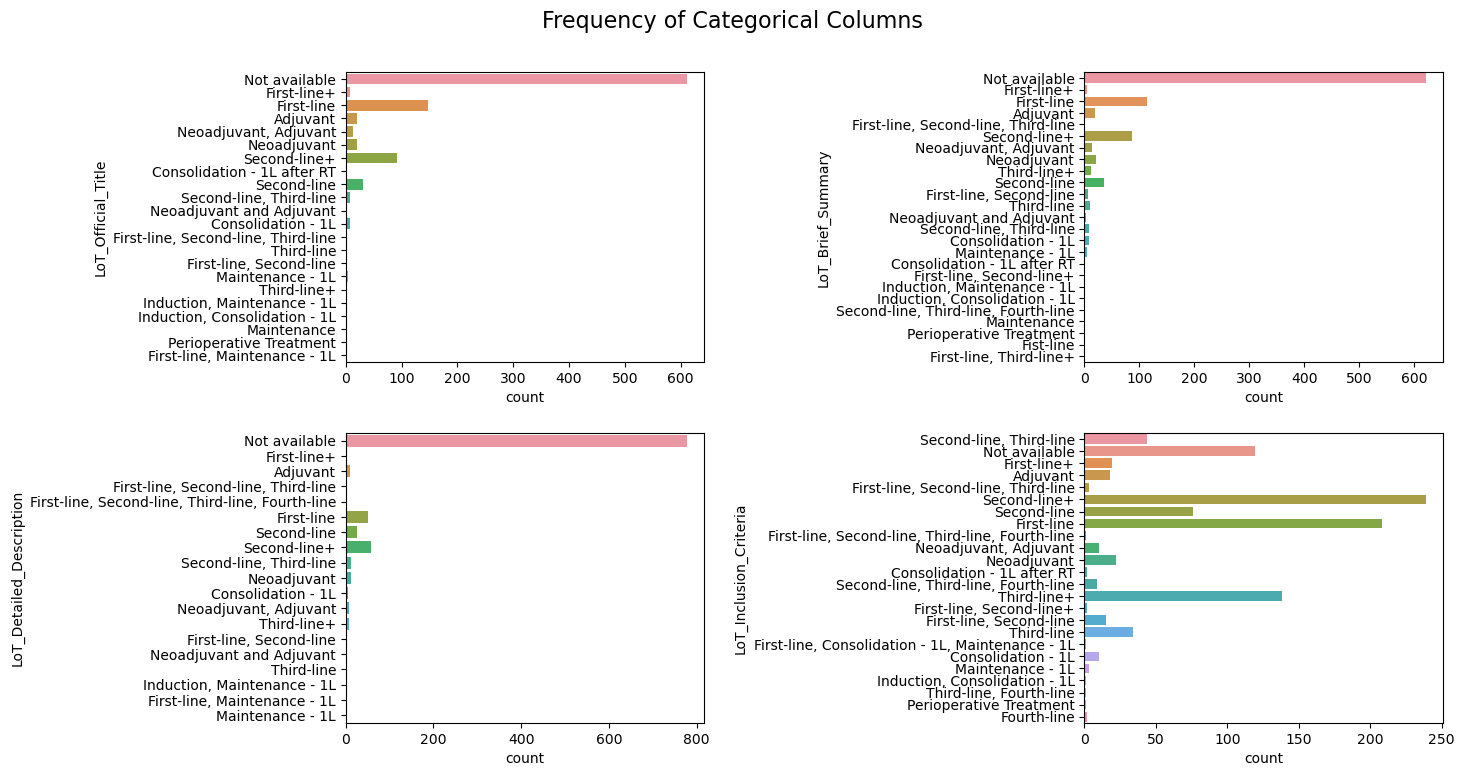

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))

# Plot the countplot for each column side by side
plt.subplot(2, 2, 1)
sns.countplot(y='LoT_Official_Title', data=master_df)
plt.subplot(2, 2, 2)
sns.countplot(y='LoT_Brief_Summary', data=master_df)
plt.subplot(2, 2, 3)
sns.countplot(y='LoT_Detailed_Description', data=master_df)
plt.subplot(2, 2, 4)
sns.countplot(y='LoT_Inclusion_Criteria', data=master_df)

# Set the title and adjust the spacing between subplots
plt.suptitle('Frequency of Categorical Columns', fontsize=16)
plt.tight_layout(pad=2.0)

# Display the plot
plt.show()

### Model 1: Prepare the data for "Brief Summary"

In [41]:
selected_col = ['NCTID','Text_field_Brief_Summary', 'LoT_Brief_Summary', 'Reason_Brief_Summary']
df_1 = master_df[selected_col].copy()
df_1[selected_col].head(10)

,NCTID,Text_field_Brief_Summary,LoT_Brief_Summary,Reason_Brief_Summary
0,NCT06003231,This clinical trial is studying advanced or me...,Not available,Relevant text not present in the trial data
1,NCT04733521,SC-43 is STAT3 inhibitor. Based on the phase I...,First-line+,Interpreted based on: 1. Based on the phase I ...
2,NCT05867121,The purpose of this study is to evaluate the s...,Not available,Relevant text not present in the trial data
3,NCT05543629,The purpose of this study is to evaluate BMS-9...,Not available,Relevant text not present in the trial data
4,NCT05005273,The purpose of this study is to determine the ...,First-line+,"Interpreted based on: 1. ""The purpose of this ..."
5,NCT05801029,This study will assess the safety and efficacy...,First-line,"Interpreted based on: ""This study will assess ..."
6,NCT04585477,In this study circulating tumor DNA (ctDNA) bl...,Adjuvant,Relevant text not present in the trial data
7,NCT04460729,The purpose of this study is to establish the ...,"First-line, Second-line, Third-line","Interpreted based on: ""The purpose of this stu..."
8,NCT05983432,The objective of this study is to evaluate the...,Not available,Relevant text not present in the trial data
9,NCT05132777,"This study is a phase II, open label, multi-ce...",Not available,Relevant text not present in the trial data


In [42]:
df_1.describe()

,NCTID,Text_field_Brief_Summary,LoT_Brief_Summary,Reason_Brief_Summary
count,1006,1006,978,978
unique,1006,1000,25,356
top,NCT06003231,Neoantigen vaccine is a new field of research ...,Not available,Relevant text not present in the trial data
freq,1,2,622,623


In [43]:
## Replace NA value with "Not available"
df_1['LoT_Brief_Summary'].fillna("Not available", inplace=True)
df_1[df_1['LoT_Brief_Summary'].isna()]

,NCTID,Text_field_Brief_Summary,LoT_Brief_Summary,Reason_Brief_Summary


In [44]:
df_1['LoT_Brief_Summary'].value_counts()

LoT_Brief_Summary
Not available                           650
First-line                              114
Second-line+                             87
Second-line                              35
Neoadjuvant                              21
Adjuvant                                 19
Neoadjuvant, Adjuvant                    13
Third-line+                              11
Third-line                               10
Second-line, Third-line                   9
Consolidation - 1L                        8
First-line, Second-line                   7
First-line+                               5
Maintenance - 1L                          4
Neoadjuvant and Adjuvant                  3
First-line, Second-line, Third-line       1
Consolidation - 1L after RT               1
First-line, Second-line+                  1
Induction, Maintenance - 1L               1
Induction, Consolidation - 1L             1
Second-line, Third-line, Fourth-line      1
Maintenance                               1
Perioperative 

In [46]:
## Correct the target label
df_1['LoT_Brief_Summary_v1'] = np.where(df_1['LoT_Brief_Summary']=='Fist-line', 'First-line',
                                        np.where(df_1['LoT_Brief_Summary']=='Neoadjuvant, Adjuvant', 'Neoadjuvant and Adjuvant',df_1['LoT_Brief_Summary']))
df_1['LoT_Brief_Summary_v1'].value_counts()

LoT_Brief_Summary_v1
Not available                           650
First-line                              115
Second-line+                             87
Second-line                              35
Neoadjuvant                              21
Adjuvant                                 19
Neoadjuvant and Adjuvant                 16
Third-line+                              11
Third-line                               10
Second-line, Third-line                   9
Consolidation - 1L                        8
First-line, Second-line                   7
First-line+                               5
Maintenance - 1L                          4
First-line, Second-line, Third-line       1
Consolidation - 1L after RT               1
First-line, Second-line+                  1
Induction, Maintenance - 1L               1
Induction, Consolidation - 1L             1
Second-line, Third-line, Fourth-line      1
Maintenance                               1
Perioperative Treatment                   1
First-line,

In [66]:
## Drop few study due to not enough sample for the predictions 
aa = df_1['LoT_Brief_Summary_v1'].value_counts()>1
selected_target_category = list(aa.index[[j for j, k in enumerate(aa) if k]])
print(df_1.shape)

df_2 = df_1[df_1['LoT_Brief_Summary_v1'].isin(selected_target_category)].reset_index(drop=True)
print('after droping the few targets from LoT : ', df_2.shape)

(1006, 5)
after droping the few targets from LoT :  (997, 5)


In [23]:
###  Extract Keywords from reason text 

selected_col = ['NCTID','Text_field_Brief_Summary', 'LoT_Brief_Summary', 'Reason_Brief_Summary']
df_1_v1 = df_1[df_1.LoT_Brief_Summary !='Not available'][['NCTID','LoT_Brief_Summary','Reason_Brief_Summary']].copy()
print(df_1_v1.shape)
df_1_v1.head()


(276, 3)


,NCTID,LoT_Brief_Summary,Reason_Brief_Summary
1,NCT04733521,First-line+,Interpreted based on: 1. Based on the phase I ...
4,NCT05005273,First-line+,"Interpreted based on: 1. ""The purpose of this ..."
5,NCT05801029,First-line,"Interpreted based on: ""This study will assess ..."
6,NCT04585477,Adjuvant,Relevant text not present in the trial data
7,NCT04460729,"First-line, Second-line, Third-line","Interpreted based on: ""The purpose of this stu..."


In [ ]:
### Text Cleaning Process

In [ ]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# Download necessary NLTK data
nltk.download('punkt')

# Tokenize the sentence
sentence = "Your sentence goes here."
tokens = nltk.word_tokenize(sentence)

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the tokens
tfidf_matrix = vectorizer.fit_transform([' '.join(tokens)])

# Get feature names to use as keywords
feature_names = vectorizer.get_feature_names_out()

# Get the tf-idf score and pair it with the feature name
scores = zip(feature_names, tfidf_matrix.toarray()[0])

# Sort by score and get top-ranking keywords
top_keywords = sorted(scores, key=lambda x: x[1], reverse=True)[:5]  # Get top 5 keywords

print(top_keywords)
